# Cat Dog Example
Here, we coding for the Cat Dog example. Recalling that the data is a 3 pixels vector. In each pixel, there are 2 choices, black or white. Only one black pixel means there is a cat. For example, $ [0,1,0] $ means there is a cat, while $ [0,1,1] $ or $ [1,0,1] $ means there is not a cat. Base on this, we create a sample set $ \mathcal{S}_c =\{(\text{image}, \text{label})\} $, and also a test set $ \mathcal{T}_c = \{(\text{other image}, \text{label})\} $.

In [1]:
S_c = [([0,1,0], 1), ([0,1,1], -1), ([1,0,1], -1), ([1,1,1], -1)]
T_c = [([1,0,0], 1), ([0,0,1], 1), ([1,0,1], -1), ([0,0,0], -1)]

Then, we encode them to quantum states. 
$$ [0, 1, 0] \to \ket{\psi} = \ket{010} $$ 
In this way, we could get a quantum version of sample set $ \mathcal{S}$ and test set $\mathcal{T}$. 

In [2]:
import numpy as np
def encode(data: list) -> np.array:
    n = len(data)
    N = 2 ** n
    psi = np.zeros(N)
    index = sum([i * 2**k for k,i in enumerate(data)])
    psi[index] = 1
    return psi
print(encode([0,0,0]))
print(encode([1,1,0])) # binary 011 = 3, its on 4-th pixel

[1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0.]


In [3]:
S = [(encode(s[0]), s[1]) for s in S_c]
T = [(encode(t[0]), t[1]) for t in T_c]

Using a very naive neural network to training the data. The model is show in following figure

In [4]:
from qiskit.circuit import QuantumCircuit, ParameterVector
theta = ParameterVector('θ', 9)
qc = QuantumCircuit(3)
qc.p(theta[0], 0)
qc.p(theta[1], 1)
qc.p(theta[2], 2)

qc.ry(theta[3], 0)
qc.ry(theta[4], 1)
qc.ry(theta[5], 2)

qc.cnot(0,1)
qc.cnot(1,2)
qc.cnot(2,0)

qc.ry(theta[6], 0)
qc.ry(theta[7], 1)
qc.ry(theta[8], 2)

qc.draw()


┌─────────┐┌──────────┐          ┌───┐┌──────────┐
q_0: ┤ P(θ[0]) ├┤ Ry(θ[3]) ├──■───────┤ X ├┤ Ry(θ[6]) ├
     ├─────────┤├──────────┤┌─┴─┐     └─┬─┘├──────────┤
q_1: ┤ P(θ[1]) ├┤ Ry(θ[4]) ├┤ X ├──■────┼──┤ Ry(θ[7]) ├
     ├─────────┤├──────────┤└───┘┌─┴─┐  │  ├──────────┤
q_2: ┤ P(θ[2]) ├┤ Ry(θ[5]) ├─────┤ X ├──■──┤ Ry(θ[8]) ├
     └─────────┘└──────────┘     └───┘     └──────────┘

In [5]:
from My_qcirc import CX, Ry, Phase, tensor

def threeTensor(gate, thetas:list):
    res = tensor(gate( thetas.pop() ), gate( thetas.pop() ))
    res = tensor(res, gate(thetas.pop()))
    return res

def qCirc(state, parameters):
    thetas = list(parameters)
    PhaseGates = threeTensor(Phase, thetas)
    Rys_1 = threeTensor(Ry, thetas)
    Rys_2 = threeTensor(Ry, thetas)
    
    Cnots = CX(2,0,3) @ CX(1,2,3) @ CX(0,1,3) 
    
    return Rys_2 @ Cnots @ Rys_1 @ PhaseGates @ np.array(state).transpose()

In [6]:
state0 = [1,0,0,0,0,0,0,0] # |0,0,0>
paras = [0,0,0,0,0,0,0,0,0]
print(qCirc(state0, paras)) # expect: [1,0,0,0,0,0,0,0]
# result conforms the expectation

state1 = [0,1,0,0,0,0,0,0] # |0,0,1> -> |1,0,1>
paras = [0,0,0,0,0,0,0,0,0]
print(qCirc(state1, paras)) # expect: [0,0,0,0,0,1,0,0]
# result conforms the expectation

[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]


# Effectiveness
The neural net could be trained to solve Cat Dog problem. We will explain the reason here. The discussion of reason includes 2 parts. The first part is a classical algorithm to solve Cat Dog problem. The second part is that, the neural net will become the classical algorithm with certain parameter.

The classical algorithm is XOR. Following table is the truth table of XOR.

| input 1 | input 2 | output |
| ------- | ------- | ------ |
|    0    |    0    |    0   |
|    0    |    1    |    1   |
|    1    |    0    |    1   |
|    1    |    1    |    0   |

Thus, the XOR gate could solve the problem for 2 pixels. The quantum corresponding of XOR is CNOT. So we could achieve XOR in quantum circuit. Thus, CNOT solve the problem for 2 pixels.

For 3 pixels, we apply 2 XORs, which is CNOT(0,1)CNOT(1,2). The bug is 111.

| input 1 | input 2 | input3 | output |
| ------- | ------- | ------ | ------ | 
|    0    |    0    |    0   |    0   |
|    0    |    0    |    1   |    1   |
|    0    |    1    |    0   |    1   |
|    0    |    1    |    1   |    0   |
|    1    |    0    |    0   |    1   |
|    1    |    0    |    1   |    0   |
|    1    |    1    |    0   |    0   |
|    1    |    1    |    1   |    1   |

Lets try CNOT(0,1)CNOT(1,2)CNOT(2,0) 

| input 1 | input 2 | input 3 | qubit 1 | qubit 2 | qubit 3 | label |
| ------- | ------- | ------- | ------- | ------- | ------- | ----- |
|    0    |    0    |    0    |    0    |    0    |    0    |   0   |
|    0    |    0    |    1    |    1    |    0    |    1    |   1   |
|    0    |    1    |    0    |    1    |    1    |    1    |   1   |
|    0    |    1    |    1    |    0    |    1    |    0    |   0   |
|    1    |    0    |    0    |    0    |    1    |    1    |   1   |
|    1    |    0    |    1    |    1    |    1    |    0    |   0   |
|    1    |    1    |    0    |    1    |    0    |    0    |   0   |
|    1    |    1    |    1    |    0    |    0    |    1    |   0   |

Finally, we find that, the third qubit of Cat picture is 1, but the first 2 pixels can not both be 0. Thus, we could assign weight to 3 pixels, such as 0.3, 0.3, 0.8. Then, sum the weight.

| input 1 | input 2 | input 3 | qubit 1 | qubit 2 | qubit 3 |sum weight| label |
| ------- | ------- | ------- | ------- | ------- | ------- | -------- | ----- |
|    0    |    0    |    0    |    0    |    0    |    0    |     0    |   0   |
|    0    |    0    |    1    |    1    |    0    |    1    |    1.1   |   1   |
|    0    |    1    |    0    |    1    |    1    |    1    |    1.4   |   1   |
|    0    |    1    |    1    |    0    |    1    |    0    |    0.3   |   0   |
|    1    |    0    |    0    |    0    |    1    |    1    |    1.1   |   1   |
|    1    |    0    |    1    |    1    |    1    |    0    |    0.6   |   0   |
|    1    |    1    |    0    |    1    |    0    |    0    |    0.3   |   0   |
|    1    |    1    |    1    |    0    |    0    |    1    |    0.8   |   0   |

so we could judge the summed weight $s$, the figure contains a cat if and only if $s > 0.95$. 

The weight could be assigned by rotation. Try $R_y(0.3 \times 2\pi)$. 

In [7]:
from qiskit.circuit import QuantumCircuit, ParameterVector
qc = QuantumCircuit(3)

qc.cnot(0,1)
qc.cnot(1,2)
qc.cnot(2,0)

qc.ry(1.88, 0) # 0.6 pi
qc.ry(1.88, 1) # 0.6 pi
qc.ry(5.03, 2) # 0.8 pi

qc.draw()


┌───┐┌──────────┐
q_0: ──■───────┤ X ├┤ Ry(1.88) ├
     ┌─┴─┐     └─┬─┘├──────────┤
q_1: ┤ X ├──■────┼──┤ Ry(1.88) ├
     └───┘┌─┴─┐  │  ├──────────┤
q_2: ─────┤ X ├──■──┤ Ry(5.03) ├
          └───┘     └──────────┘

The hypothesis function is 
$$ \hat{f}_\theta(\rho) = tr(U\rho U^\dagger O) 
$$
where $U$ is the quantum circuit in above circuit, $O = Z\otimes 1 \otimes 1 + 1\otimes Z \otimes 1 + 1\otimes 1 \otimes Z$

In [8]:
from My_qcirc import dagger, Id, Z
O = tensor(Z, Id, Id) + tensor(Id, Z, Id) + tensor(Id, Id, Z)
def test_cost_function(state):
    Cnots = CX(2,0,3) @ CX(1,2,3) @ CX(0,1,3)
    Rys_1 = threeTensor(Ry, [1.5, 1.8, 5.03])
    fin_state = Rys_1 @ Cnots @ np.array(state).transpose()
    return fin_state @ O @ dagger(fin_state)

After few attempts, I found a set of parameter that could separate cat and dog. the parameters are 1.5, 1.8, 5.03

In [9]:
state = [1,0,0,0,0,0,0,0] # |000>
test_cost_function(state)

for i in range(8):
    state = np.zeros(8)
    state[i] = 1
    print("input: %s, output: %f" % (bin(i), test_cost_function(state)))

input: 0b0, output: -2.691691
input: 0b1, output: 0.898174
input: 0b10, output: 2.691691
input: 0b11, output: -0.898174
input: 0b100, output: 1.081811
input: 0b101, output: 0.711706
input: 0b110, output: -1.081811
input: 0b111, output: -0.711706


the threshold is 0.8. If the output is larger than 0.8, the image includes a cat.

In this section, I illustrate the existence for perfect classification of Cat Dog problem. And also shows how to construct the quantum neural network.

# Cost Function

To begin with, let's try a naive cost function
$$
C(\theta) = \sum_i \exp\Big[f(\rho_i)\bigg(f(\rho_i) - \hat{f}_\theta(\rho_i)\bigg)\Big]
$$

In [10]:
from numpy import exp

Cnots = CX(2,0,3) @ CX(1,2,3) @ CX(0,1,3) 
def hyp_func(state, parameters):
    "the length of parameters should be 3"
    Rys_2 = tensor(Ry(parameters[0]), Ry(parameters[1]), Ry(parameters[2]))
    
    fin_state = Rys_2 @ Cnots @  np.array(state).transpose()
    res = fin_state @ O @ dagger(fin_state)
    return np.array(res)[0][0]

def Cost(para):
    arry = [ exp( label * (label - hyp_func(state, para))) for state, label in S]
    return sum(arry)

In [11]:
# test
Cost([1.5, 1.8, 5.03])

10.458781270069741

## Gradient descent


In [12]:
def grad(para):
    eps = 0.001
    gradient = [0,0,0]
    para = np.array(para)
    eps_arry = np.zeros(3)
    for i in range(3):
        eps_arry[i] = eps
        para_l = para - eps_arry
        para_r = para + eps_arry
        gradient[i] = (Cost(para_r) - Cost(para_l)) / (2*eps)    
    return gradient

# def descent(para:np.array, x_record:list, y_record:list, lrn_rate = 0.01 ) -> None:
#     "record the value of cost function and update the parameter"
#     x_record.append(para)
#     y_record.append(Cost(para))
#     gradient = grad(para)
#     para = para - lrn_rate * np.array(gradient) 


In [13]:
grad([1.5, 1.8, 5.03])

[2.3277596607051976, -2.6100078865232135, 7.614546265517497]

In [14]:
from random import random
from numpy import pi
from copy import deepcopy

max_step = 100
x_record = []
y_record = []
initial_para = np.array([random()*2*pi, random()*2*pi, random()*2*pi])
initial_para_copy = deepcopy(initial_para)

def descent( lrn_rate = 0.01 ) -> None:
    global initial_para
    x_record.append(initial_para)
    y_record.append(Cost(initial_para))
    gradient = grad(initial_para)
    initial_para = initial_para - lrn_rate * np.array(gradient) 
    
for i in range(max_step):
    descent()    

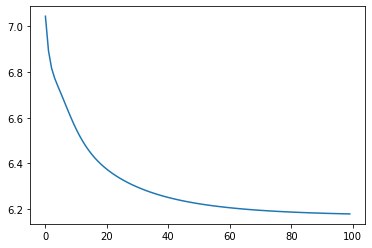

In [15]:
import matplotlib.pyplot as plt
plt.plot(y_record)

In [16]:
trained_para = x_record[-1]

def test_cost_function(state, para):
    Cnots = CX(2,0,3) @ CX(1,2,3) @ CX(0,1,3)
    Rys_1 = threeTensor(Ry, [1.5, 1.8, 5.03])
    fin_state = Rys_1 @ Cnots @ np.array(state).transpose()
    return fin_state @ O @ dagger(fin_state)

for i in range(8):
    state = np.zeros(8)
    state[i] = 1
    print("input: %s, output: %f" % (bin(i), test_cost_function(state, trained_para)))
    

input: 0b0, output: -2.691691
input: 0b1, output: 0.898174
input: 0b10, output: 2.691691
input: 0b11, output: -0.898174
input: 0b100, output: 1.081811
input: 0b101, output: 0.711706
input: 0b110, output: -1.081811
input: 0b111, output: -0.711706


From this result, we could see that the training is success because images could be separate by threshold 0.8.


# Symmetry Guidance
We have seen that the training is success. Now, lets construct the symmetry guidance. 

The first step is calculating the symmetry group. 
The classification mission is SWAP invariance because the label of an image is unchanged under swap operation. Thus, we construct the free group $H$ of swap operation.
$$
H = \{ \prod\text{SWAP}(i,j)~|~ i\not=j, i,j = 1,2,3 \}
$$

In [17]:
from My_qcirc import generate_freegroup, SWAP

H = generate_freegroup([SWAP(0,1,3), SWAP(1,2,3), SWAP(2,0,3)])

Then construct the symmetry guidance
$$
\tilde{O} = UOU^\dagger
$$

$$
P\tilde{O} = \sum S\tilde{O}S^\dagger
$$


In [18]:
from My_qcirc import Ad
def qc(paras: np.array) -> np.matrix:
    Rys_2 = tensor(Ry(paras[0]), Ry(paras[1]), Ry(paras[2]))
    return  Rys_2 @ Cnots 

def PO(paras: np.array) -> np.matrix:
    O_tilde = Ad(qc(paras), O)
    SOS_list = [Ad(symmetry_op, O_tilde) for symmetry_op in H ]
    return 1/6 * sum(SOS_list)
    

In [19]:
# test qc
print(qc(np.array([0,0,0])))
print(Cnots)
# qc looks good

# The correction of PO is waiting for check.

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]
[[1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0]]


In [20]:
O_tilde = Ad(qc(paras), O)
H[0] @ O_tilde @ dagger(H[0]) + H[1] @ O_tilde @ dagger(H[1]) + H[2] @ O_tilde @ dagger(H[2]) \
    + H[3] @ O_tilde @ dagger(H[3]) + H[4] @ O_tilde @ dagger(H[4]) + H[5] @ O_tilde @ dagger(H[5])

matrix([[ 18.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0., -10.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0., -10.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0., -10.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   6.]])

In [21]:
print(PO(np.array([0,0,0])))
# PO seems correct, too.

[[ 3.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.         -1.66666667  0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.         -1.66666667  0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.33333333  0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.         -1.66666667  0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.33333333
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.33333333  0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          1.        ]]


Then, we can calculate the symmetry guidance
$$
g = || P\tilde{O} - \tilde{O} || 
% \sim -tr(P\tilde{O}(2\tilde{O} - P\tilde{O}))
$$
And the cost function is
$$
C'(\theta) = C(\theta) + \lambda g
% \sim C(\theta) - \lambda tr(P\tilde{O}(2\tilde{O} - P\tilde{O}))
$$

In [22]:
from numpy import trace
def g(para):
   O_tilde = Ad(qc(paras), O)
   _PO = PO(para)
   _A = _PO - O_tilde
   _size = 0.08
   return _size * trace(_A @ dagger(_A))

In [23]:
lamb = 4

def Cost_g(para) -> float:
    return Cost(para) + lamb * g(para)


# Gradient descent with guidance

In [24]:
def grad_g(para):
    eps = 0.001
    gradient = [0,0,0]
    para = np.array(para)
    eps_arry = np.zeros(3)
    for i in range(3):
        eps_arry[i] = eps
        para_l = para - eps_arry
        para_r = para + eps_arry
        gradient[i] = (Cost_g(para_r) - Cost_g(para_l)) / (2*eps)    
    return gradient

x_record_g = []
y_record_g = []

def descent_g( lrn_rate = 0.01 ) -> None:
    global initial_para_copy
    x_record_g.append(initial_para_copy)
    y_record_g.append(Cost(initial_para_copy))
    gradient = grad_g(initial_para_copy)
    initial_para_copy = initial_para_copy - lrn_rate * np.array(gradient) 
    
for i in range(max_step):
    descent_g()    

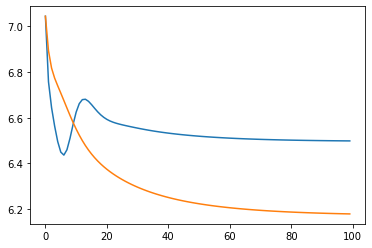

In [25]:
plt.plot(y_record_g)
plt.plot(y_record)

In [26]:
np.array(grad(initial_para)) - np.array(grad_g(initial_para))

array([-7.15214631, -5.07292293, -2.86734294])

In [27]:
Cost(initial_para) - Cost_g(initial_para)

-6.45172045143628

In [28]:
para = initial_para
eps = 0.001
gradient = [0,0,0]
para = np.array(para)
eps_arry = np.zeros(3)
for i in range(3):
    eps_arry[i] = eps
    para_l = para - eps_arry
    para_r = para + eps_arry
    gradient[i] = (Cost(para_r) - Cost(para_l)) / (2*eps)  

sg想要让不同输入在swap下的值保持一致。但事实上，swap下输出不一致的线路也可以很好地完成任务。干！

现在想先看看，两个训练后的参数在Test集上的表现怎么样。

In [29]:
para = x_record[-1]
para_g = x_record_g[-1]
QC = qc(para)
QC_g = qc(para_g)

def test_cost(qc):
    fin_state = qc @ np.array(state).transpose()
    return fin_state @ O @ dagger(fin_state)

test_err = sum([ exp( label * (label - hyp_func(state, para))) for state, label in T])
test_err_g = sum([ exp( label * (label - hyp_func(state, para_g))) for state, label in T])

print(test_err)
print(test_err_g)

6.215729202461436
6.492728111519731


In [30]:
def test_cost_function(state, para):
    Cnots = CX(2,0,3) @ CX(1,2,3) @ CX(0,1,3)
    Rys_1 = tensor(Ry(para[0]), Ry(para[1]), Ry(para[2]))
    fin_state = Rys_1 @ Cnots @ np.array(state).transpose()
    return fin_state @ O @ dagger(fin_state)

for i in range(8):
    state = np.zeros(8)
    state[i] = 1
    print("input: %s, output: %f" % (bin(i), test_cost_function(state, para)))

input: 0b0, output: -1.983871
input: 0b1, output: -0.013580
input: 0b10, output: 1.983871
input: 0b11, output: 0.013580
input: 0b100, output: 1.997671
input: 0b101, output: -0.000220
input: 0b110, output: -1.997671
input: 0b111, output: 0.000220


In [31]:
right_num = 0
for state, label in T:
    if hyp_func(state, para_g) > 0 == label: right_num +=1
    ind = np.where(state ==1)
    print("input: %s, output: %f" % (bin(ind[0][0]), test_cost_function(state, para_g)))
    
print(right_num/8)

input: 0b1, output: -0.321438
input: 0b100, output: 2.320030
input: 0b101, output: -0.323018
input: 0b0, output: -1.675574
0.0


In [32]:
right_num = 0
for state, label in T:
    num = test_cost_function(state, para_g)
    num = np.array(num)[0][0]
    if (num > 0) == label: right_num +=1
    ind = np.where(state ==1)
    print("input: %s, output: %f" % (bin(ind[0][0]), num))
    
print(right_num/8)

input: 0b1, output: -0.321438
input: 0b100, output: 2.320030
input: 0b101, output: -0.323018
input: 0b0, output: -1.675574
0.125


In [33]:
numright_num = 0
for state, label in T:
    num = test_cost_function(state, para)
    num = np.array(num)[0][0]
    if (num > 0) == label: right_num +=1
    ind = np.where(state ==1)
    print("input: %s, output: %f" % (bin(ind[0][0]), num))
    
print(right_num/8)

input: 0b1, output: -0.013580
input: 0b100, output: 1.997671
input: 0b101, output: -0.000220
input: 0b0, output: -1.983871
0.25


似乎guidance的存在反而降低了模型的准确率。

现在选取一些方向，看看在这个方向上的cost

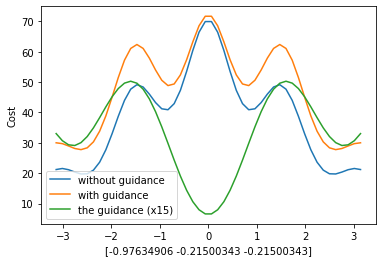

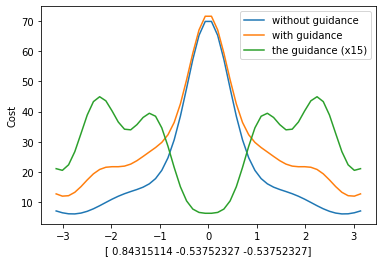

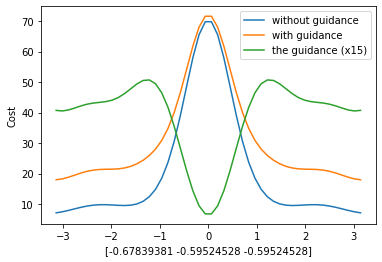

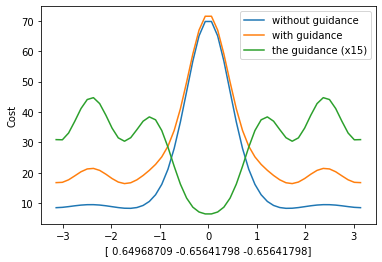

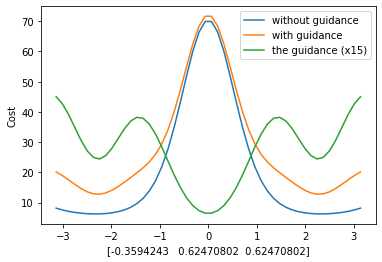

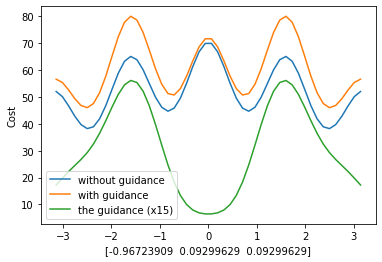

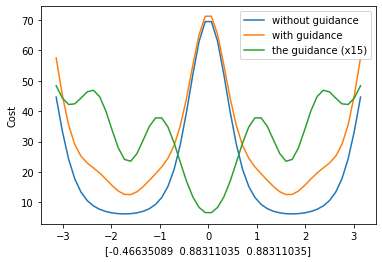

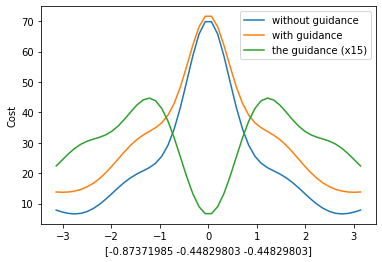

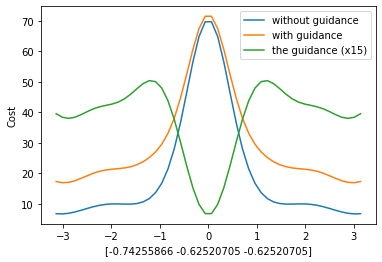

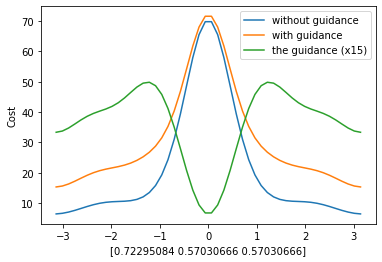

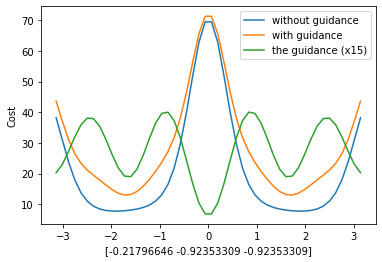

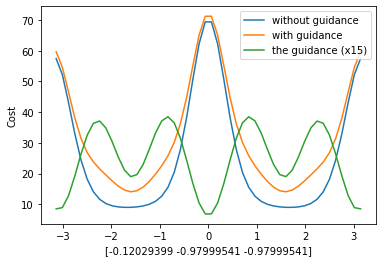

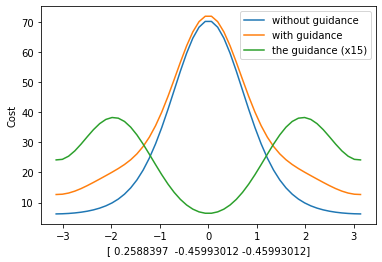

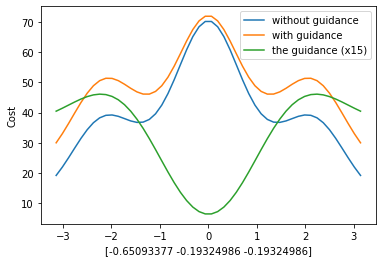

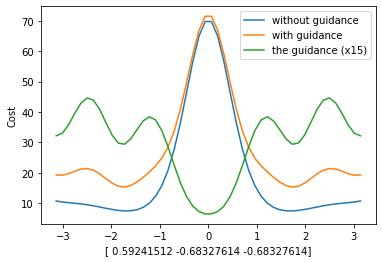

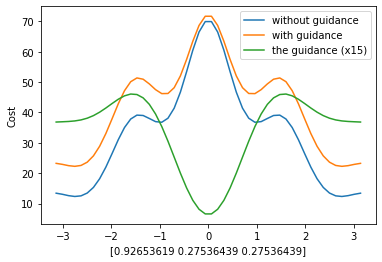

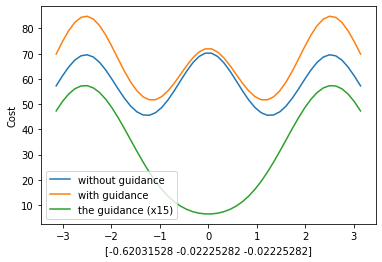

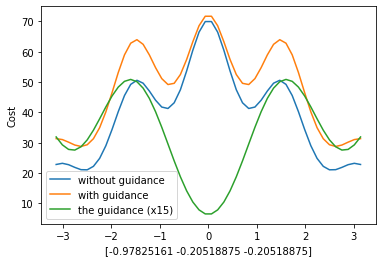

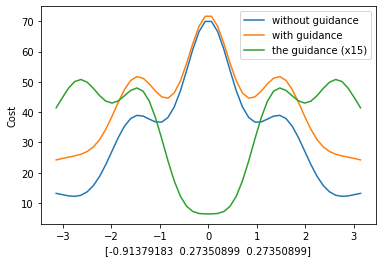

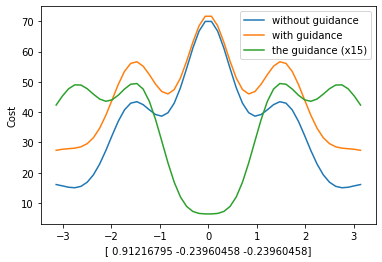

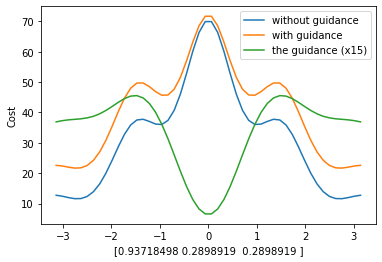

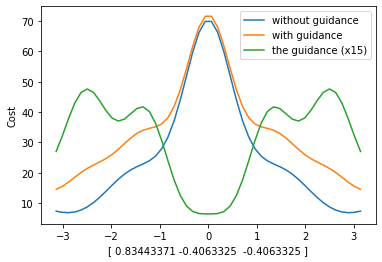

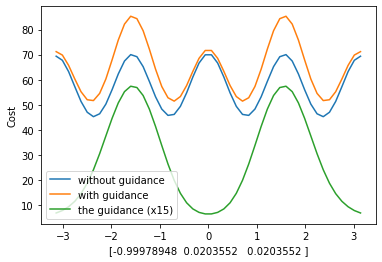

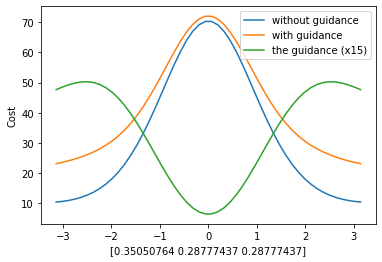

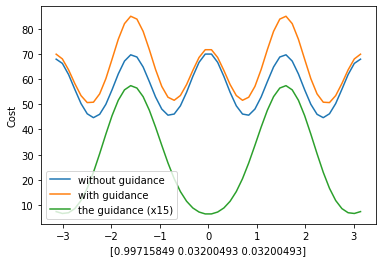

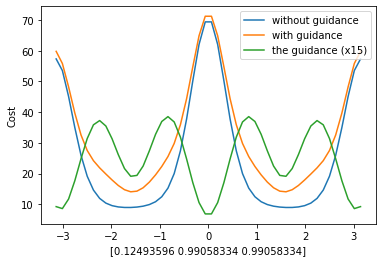

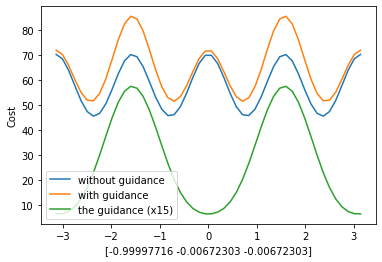

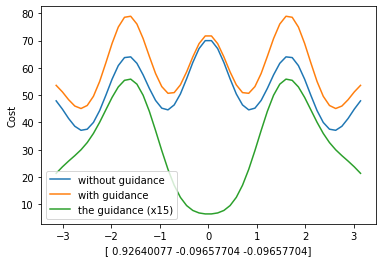

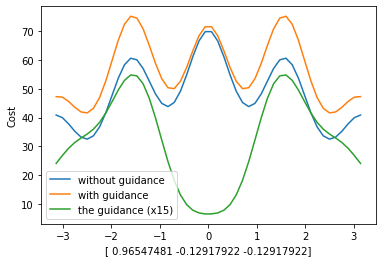

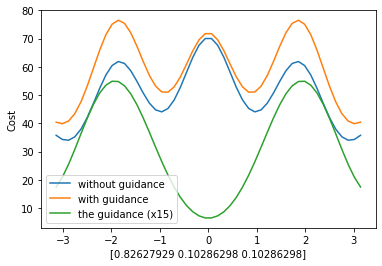

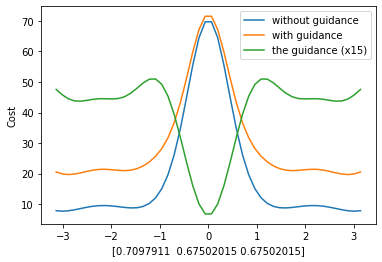

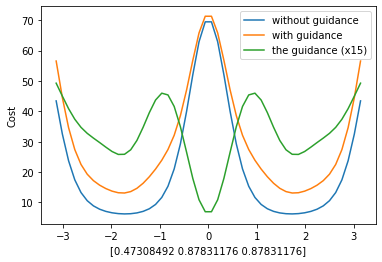

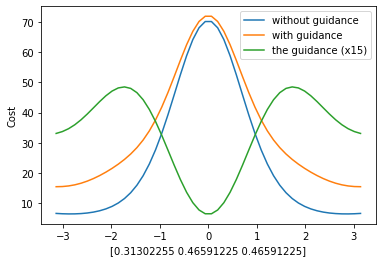

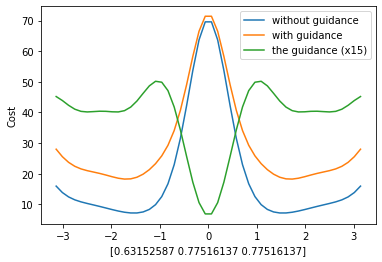

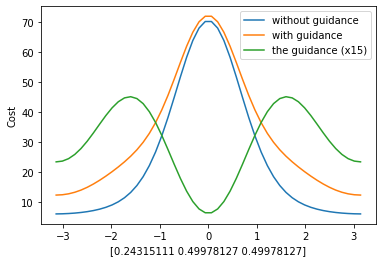

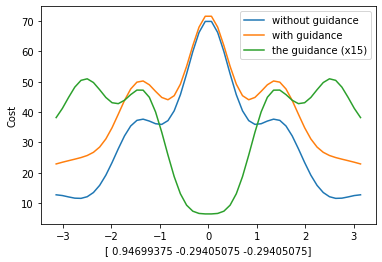

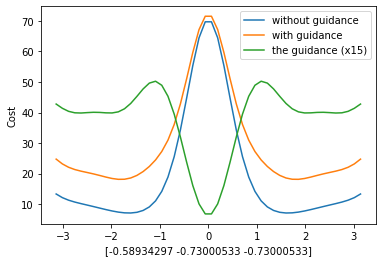

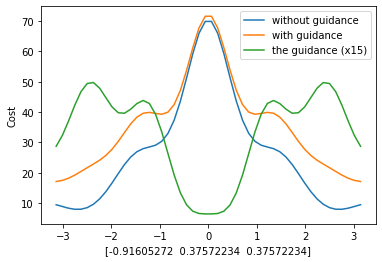

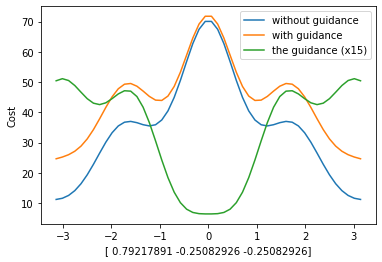

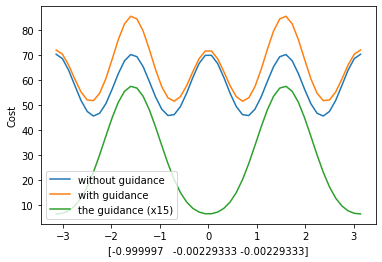

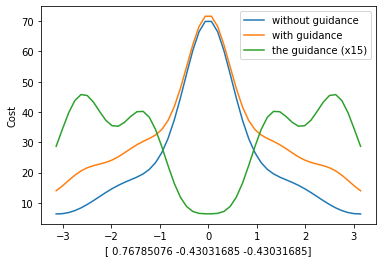

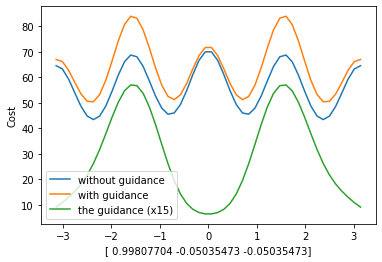

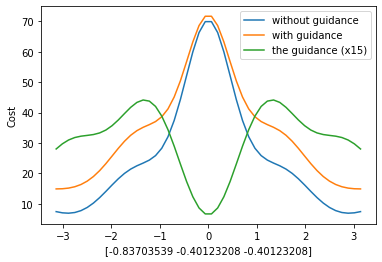

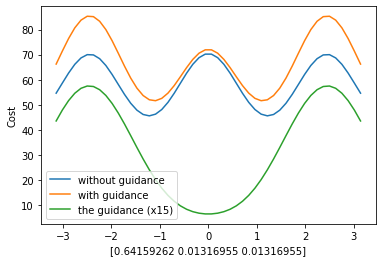

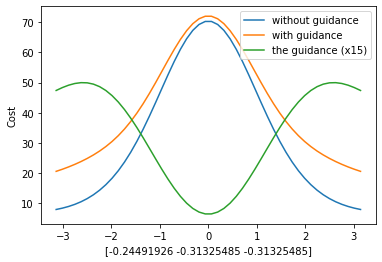

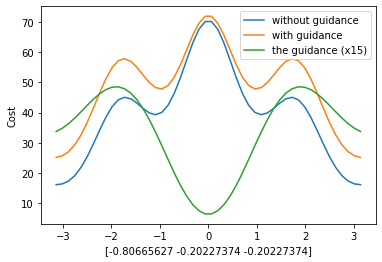

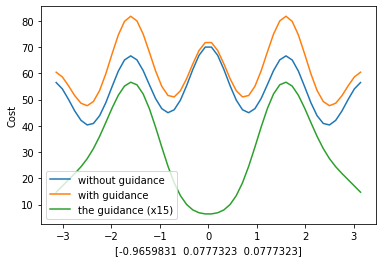

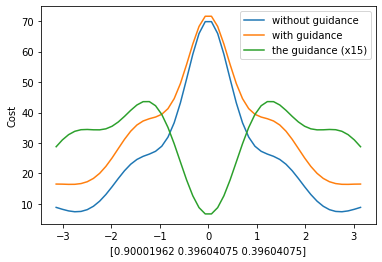

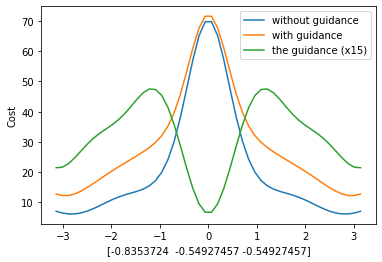

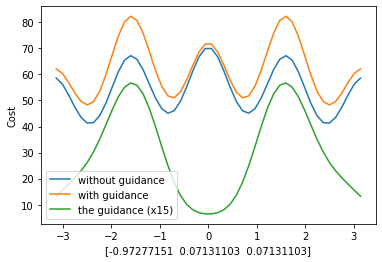

In [34]:
from numpy import sin, cos

for i in range(50):    
    thetas = 2*pi* np.random.random(2)
    n_hat = np.array([cos(thetas[0]), sin(thetas[0]) * cos(thetas[1]), sin(thetas[0]) * cos(thetas[1])])
    x = np.linspace(-pi, pi)
    para_list = [ x0 * n_hat for x0 in x]
    y = [ Cost(p) for p in para_list ]
    y_g = [ Cost_g(p) for p in para_list ]
    gd = [ 15*g(p) for p in para_list ]
    
    plt.xlabel(str(n_hat))
    plt.ylabel('Cost')
    plt.plot(x,y, label='without guidance')
    plt.plot(x,y_g, label='with guidance')
    plt.plot(x,gd, label='the guidance (x15)')
    plt.legend()

    plt.savefig('cost_%d' % i)
    plt.show()

# Conclusions from results
The symmetry guidance performs not good in this model.
+ symmetry guidance lead the parameter to the symmetry conserved position. However, in this model, the output of hypothesis model is not directly be the label. The output is the probability, (e.g., output 2.7 means it has high probability to get label 1). Although the label of $[0,0,1]$ and $[0,1,0]$ should be the same, probability of getting the correct result could be different.
+ This is root in the cost function. The training of cost function depends on the probability rather than the label. But for 3 qubits case, the cost function that only depends on labels is hard to train. To be specify, there are only 8 results for 3 bits. Let cost function is $\sum (\hat{f}_\theta(\rho_i) - f(\rho_i))^2$. For one sample, if the prediction is correct, $ (\hat{f}_\theta(\rho_i) - f(\rho_i))^2 =0$, otherwise its 4. Thus, for 3 bits, cost function could only get 8 values. Such function is hard to gradient descent
+ There is no parameter that makes the probability distribution symmetry. 
+ In the (circuit model) quantum setting, it has been shown that while underparameterized Quantum Neural Networks (QNNs) have spurious local minima in the loss landscape, overparameterized QNNs make the landscape more favorable and thus substantially improve a trainability of QNNs (Kim & Marvian, 2022). Thus, adding some parameters may help.